In [1]:
import pandas as pd 
import numpy as np 
import random, tqdm
from time import time

import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

from rasterio.plot import  show, adjust_band
import rasterio
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")



from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torchvision
from torchvision import  models
from torch.nn import functional as F

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
images_dirs = []
masks_dirs = []
images = np.array([], np.float32)
masks = np.array([], np.float32)
from skimage.io import imread 
import os 
main_root = "../input/stavropol-sentinel2-vol2/data"


for root, dirs, files in os.walk(main_root):
   # приходится колхозить(
        if root.endswith('image'):
            for file in files:
                images_dirs.append(os.path.join(root, file))
        if root.endswith('mask'):
            for file in files:
                masks_dirs.append(os.path.join(root, file))
                
 

In [3]:
size = (256, 256)

#for i in tqdm(range(len(images_dirs))):
for i in tqdm(range(200)):
    image = imread(images_dirs[i])         
    image = resize(image, size, mode='constant', anti_aliasing=True,) # ресайз в 512
    image = adjust_band(image) # конвертация в диапозон [0,1]
    image = np.array(image, np.float32)
    images = np.append(images,image )
        
    mask = imread(masks_dirs[i])
    mask = resize(mask, size, mode='constant', anti_aliasing=False) > 0#ресайз в 512
    mask = np.array(mask, np.float32) 
    masks = np.append(masks,mask )
    
   

100%|██████████| 200/200 [00:20<00:00,  9.68it/s]


In [5]:
#images = images.reshape(len(images_dirs),256,256,4)
#masks = masks.reshape(len(images_dirs),256,256)

images = images.reshape(200,256,256,4)
masks = masks.reshape(200,256,256)

у нас есть проблема , при проецировании и обрезке кусочков снимков , получилось что у части снимков есть полосочка с нулями, надо посчитать минимум не беря в расчет эти нолики

Text(0.5, 1.0, 'MASKS')

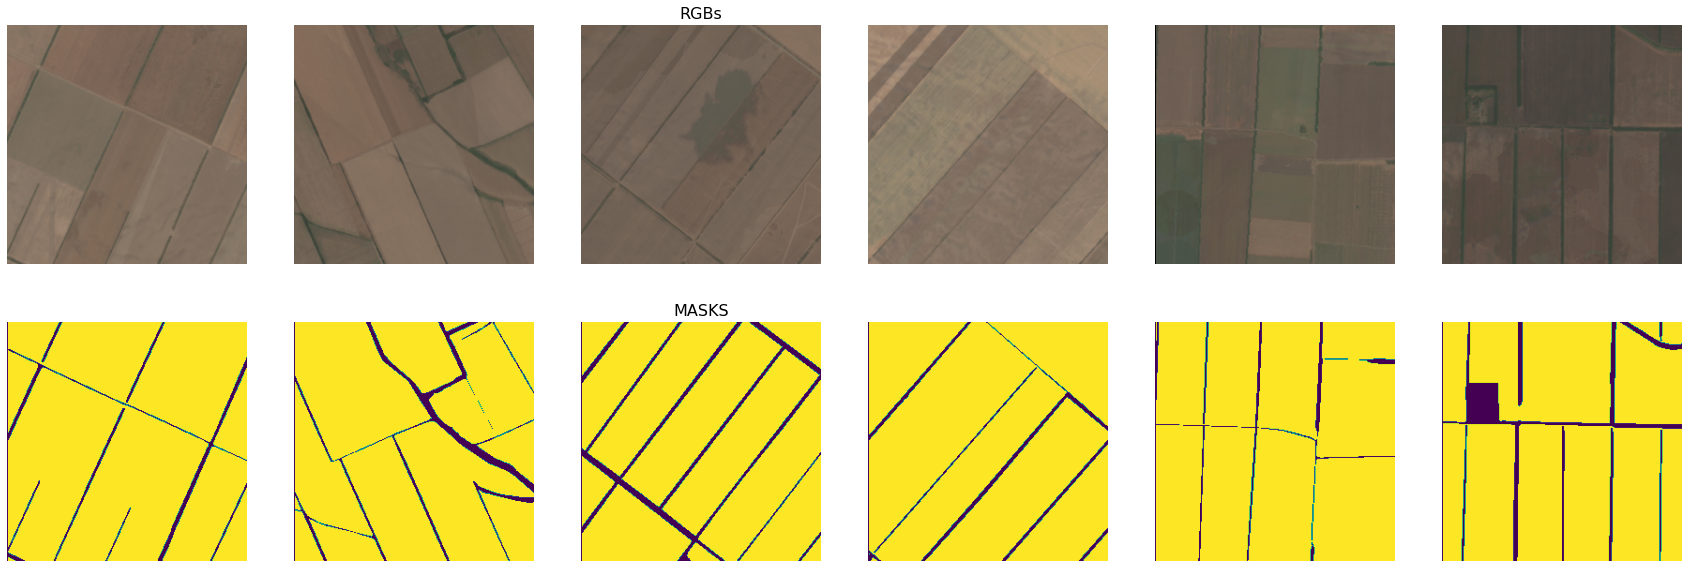

In [6]:
fig, axes = plt.subplots(2,6, figsize=(30,10)) 
for i in range(6):
    dataset = rasterio.plot.reshape_as_raster(images[20:50][i])
    show(dataset[0:3], ax = axes[0,i])
    show(masks[20:50][i], ax = axes[1,i])
    axes[1,i].axis('off')
    axes[0,i].axis('off')
axes[0,2].set_title('RGBs', fontsize = 16)
axes[1,2].set_title('MASKS', fontsize = 16)

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(images,masks  , test_size = 0.33, random_state = 42) #небольшое ограничение чтобы сейчас все тестить как работает потом уберу
del images,masks #а то очень сильно перегружена оперативка 

In [99]:
mask = mask.reshape(100,256,256,1)

ValueError: cannot reshape array of size 65536 into shape (100,256,256,1)

### модели - буду пробовать как в статье про Данию U-net 

In [7]:
batch_size = 16 
data_tr = DataLoader(list(zip(np.rollaxis(X_train[:], 3, 1), Y_train[:, np.newaxis])), drop_last=True,batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X_test[:], 3, 1), Y_test[:, np.newaxis])), drop_last=True,batch_size=batch_size, shuffle=True)
del X_train, X_test, Y_train, Y_test

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [2]:
torch.cuda.is_available()


True

In [8]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        batchNorm_momentum = 0.1
        self.stage1 = nn.Sequential( 
                nn.Conv2d(4, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64, momentum= batchNorm_momentum),
                nn.ReLU(),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64, momentum= batchNorm_momentum),
                nn.ReLU()
            )
        self.stage2 = nn.Sequential( 
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum= batchNorm_momentum),
            nn.ReLU()
        )
        self.stage3 = nn.Sequential( 
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256, momentum= batchNorm_momentum),
            nn.ReLU()
        )
        self.stage4 = nn.Sequential( 
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512, momentum= batchNorm_momentum),
            nn.ReLU()
        )
        self.stage5 = nn.Sequential( 
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024, momentum= batchNorm_momentum),
            nn.ReLU()
        )
        self.stage5_de = nn.Sequential( 
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512, momentum= batchNorm_momentum),
            nn.ReLU()
        )
        self.stage4_de = nn.Sequential( 
            nn.Conv2d(2 * 512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256, momentum= batchNorm_momentum),
            nn.ReLU()
        )
        self.stage3_de = nn.Sequential( 
            nn.Conv2d(2 * 256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum= batchNorm_momentum),
            nn.ReLU()
        )
        self.stage2_de = nn.Sequential( 
            nn.Conv2d(2 * 128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum= batchNorm_momentum),
            nn.ReLU()
            
        )
        self.stage1_de = nn.Sequential( 
            nn.Conv2d(2 * 64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum= batchNorm_momentum),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
         #   nn.BatchNorm2d(label_nbr, momentum= batchNorm_momentum),
         #   nn.ReLU(),
           # nn.Conv2d(label_nbr, label_nbr, kernel_size=3, padding=1),
          #  nn.BatchNorm2d(label_nbr, momentum= batchNorm_momentum)
                  )


    def forward(self, x):
        # encoder
        e1 = self.stage1(x)
        e1_1, id1 = F.max_pool2d(e1,kernel_size=2, stride=2,return_indices=True)
        e2 = self.stage2(e1_1)
        e2_1, id2 = F.max_pool2d(e2,kernel_size=2, stride=2,return_indices=True)
        e3 = self.stage3(e2_1)
        e3_1, id3 = F.max_pool2d(e3,kernel_size=2, stride=2,return_indices=True)
        e4 = self.stage4(e3_1)
        e4_1, id4 = F.max_pool2d(e4,kernel_size=2, stride=2,return_indices=True)
        # bottleneck
        b = self.stage5(e4_1)
        b = self.stage5_de(b)

        # decoder
        d4 = F.max_unpool2d(b, id4, kernel_size=2, stride=2)
        d4 = self.stage4_de(torch.cat([e4,d4],1) )
        d3 = F.max_unpool2d(d4, id3, kernel_size=2, stride=2)
        d3 = self.stage3_de(torch.cat([e3,d3],1) )
        d2 = F.max_unpool2d(d3, id2, kernel_size=2, stride=2)
        d2 = self.stage2_de(torch.cat([e2,d2],1) )
        d1 = F.max_unpool2d(d2, id1, kernel_size=2, stride=2)
        d1 = self.stage1_de(torch.cat([e1,d1],1) )  
        return d1



        
        

       


метрика - в статье использовали IoU

In [9]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte() # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2)) # Will be zero if Truth=0 or Pr
    union = (outputs | labels).float().sum((1, 2))
    # Will be zzero if both are 0
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    # We smooth our devision to avoid 0/
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10
    return thresholded

In [10]:
if os.path.exists("/kaggle/working/model_state"):
    print("/kaggle/working/model_state cуществует")
else:
    
    os.mkdir("/kaggle/working/model_state")
    print('директория создана')


директория создана


In [11]:
os.path.exists("/kaggle/working/model_state") == True

True

In [12]:
def save_model(epoch,model):
  path = '/kaggle/working/model_state'
  #потому что до 14 эпохи уже досчитал 
  torch.save(model.state_dict(), path + '/model_state_' + f"{epoch}.pt")
 

In [13]:
#считаем скор 
def score_model(model, metric, data):
    model.eval() # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_pred = model(X_batch)
        Y_pred = Y_pred > 0.5
        scores += metric(Y_pred, Y_label.to(device)).mean().item()
    return scores/len(data)
#учим
def train(model, opt,scheduler, loss_fn,metric, epochs, data_tr, data_val):
    train_loss_list = []
    train_score_list = []
    val_loss_list = []
    val_score_list = []
    for epoch in tqdm(range(epochs)):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        avg_loss = 0
        avg_scores = 0
        model.train() # train mode
        for X_batch, Y_batch in data_tr:
                # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
# set parameter gradients to zero
            opt.zero_grad()
            # forward
            output = model(X_batch)
            loss = loss_fn(output,Y_batch)
            loss.backward()
            opt.step() # update weights
            # calculate loss to show the user
            avg_loss += loss.item() / len(data_tr)
        scheduler.step()
        train_loss_list.append(avg_loss) # трейн лос
        avg_score = score_model(model,metric, data_tr ) # трейн скор
        train_score_list.append(avg_score)
        toc = time()
        # валидация
        avg_loss_val = 0
        model.eval() # testing mode
        for X_val, Y_val in data_val:
            with torch.no_grad():
                Y_hat = model(X_val.to(device)).detach().cpu()# detach and put into cpu
                loss = loss_fn( Y_hat,Y_val) # forward-pass
                avg_loss_val += loss.item() / len(data_val)
        val_loss_list.append(avg_loss_val)
        avg_score_val = score_model(model,metric, data_val)
        val_score_list.append(avg_score_val)
        
        if epoch % 2 == 0: #каждые две эпохи будет сохраняться модель и состояние ее результатов 
            save_model(epoch,model) #сохраннение состояния сетки
        score_df = pd.DataFrame({
                    "epoch" : epoch + 1,
                    "train_loss" : train_loss_list,
                    "train_score" : train_score_list,
                    "val_loss" : val_loss_list,
                    "val_score" : val_score_list
                    })
        score_df.to_csv('/kaggle/working/model_state' + '/report.csv') # сохраннение скора сетки 
        print('%d / %d - train loss: %f, train score: %f ,val loss: %f,  val score: %f  ' % (epoch+1, epochs, avg_loss, avg_score, avg_loss_val,avg_score_val  ))


In [15]:
loss = nn.BCEWithLogitsLoss()
#loss = nn.BCELoss()
model = UNet()
model = model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optim, step_size=15, gamma=0.1, verbose = True)
train(model, optim,scheduler, loss,iou_pytorch, 40, data_tr, data_val )


Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/40 [00:00<?, ?it/s]

* Epoch 1/40
Adjusting learning rate of group 0 to 1.0000e-03.


  2%|▎         | 1/40 [00:51<33:12, 51.10s/it]

1 / 40 - train loss: 0.181478, train score: 0.931490 ,val loss: 0.173109,  val score: 0.929500  
* Epoch 2/40
Adjusting learning rate of group 0 to 1.0000e-03.


  5%|▌         | 2/40 [01:36<30:15, 47.76s/it]

2 / 40 - train loss: 0.119297, train score: 0.922957 ,val loss: 0.137893,  val score: 0.922750  
* Epoch 3/40
Adjusting learning rate of group 0 to 1.0000e-03.


  8%|▊         | 3/40 [02:22<28:56, 46.92s/it]

3 / 40 - train loss: 0.115121, train score: 0.936178 ,val loss: 0.124717,  val score: 0.935250  
* Epoch 4/40
Adjusting learning rate of group 0 to 1.0000e-03.


 10%|█         | 4/40 [03:08<27:50, 46.41s/it]

4 / 40 - train loss: 0.113410, train score: 0.565986 ,val loss: 0.347117,  val score: 0.548750  
* Epoch 5/40
Adjusting learning rate of group 0 to 1.0000e-03.


 12%|█▎        | 5/40 [03:53<26:56, 46.20s/it]

5 / 40 - train loss: 0.107590, train score: 0.968149 ,val loss: 0.113548,  val score: 0.963500  
* Epoch 6/40
Adjusting learning rate of group 0 to 1.0000e-03.


 15%|█▌        | 6/40 [04:39<26:04, 46.00s/it]

6 / 40 - train loss: 0.107938, train score: 0.962380 ,val loss: 0.120115,  val score: 0.956500  
* Epoch 7/40
Adjusting learning rate of group 0 to 1.0000e-03.


 18%|█▊        | 7/40 [05:25<25:16, 45.94s/it]

7 / 40 - train loss: 0.107320, train score: 0.964183 ,val loss: 0.116486,  val score: 0.963000  
* Epoch 8/40
Adjusting learning rate of group 0 to 1.0000e-03.


 20%|██        | 8/40 [06:10<24:27, 45.85s/it]

8 / 40 - train loss: 0.100733, train score: 0.938341 ,val loss: 0.136529,  val score: 0.937750  
* Epoch 9/40
Adjusting learning rate of group 0 to 1.0000e-03.


 22%|██▎       | 9/40 [06:56<23:41, 45.85s/it]

9 / 40 - train loss: 0.098564, train score: 0.965024 ,val loss: 0.105208,  val score: 0.959500  
* Epoch 10/40
Adjusting learning rate of group 0 to 1.0000e-03.


 25%|██▌       | 10/40 [07:42<22:53, 45.78s/it]

10 / 40 - train loss: 0.098056, train score: 0.955769 ,val loss: 0.110762,  val score: 0.948500  
* Epoch 11/40
Adjusting learning rate of group 0 to 1.0000e-03.


 28%|██▊       | 11/40 [08:28<22:07, 45.79s/it]

11 / 40 - train loss: 0.094590, train score: 0.971274 ,val loss: 0.109355,  val score: 0.967250  
* Epoch 12/40
Adjusting learning rate of group 0 to 1.0000e-03.


 30%|███       | 12/40 [09:13<21:20, 45.73s/it]

12 / 40 - train loss: 0.093731, train score: 0.963822 ,val loss: 0.100545,  val score: 0.959750  
* Epoch 13/40
Adjusting learning rate of group 0 to 1.0000e-03.


 32%|███▎      | 13/40 [09:59<20:35, 45.76s/it]

13 / 40 - train loss: 0.094090, train score: 0.970913 ,val loss: 0.104853,  val score: 0.967750  
* Epoch 14/40
Adjusting learning rate of group 0 to 1.0000e-03.


 35%|███▌      | 14/40 [10:45<19:49, 45.73s/it]

14 / 40 - train loss: 0.091090, train score: 0.974159 ,val loss: 0.115525,  val score: 0.966750  
* Epoch 15/40
Adjusting learning rate of group 0 to 1.0000e-04.


 38%|███▊      | 15/40 [11:31<19:04, 45.77s/it]

15 / 40 - train loss: 0.090381, train score: 0.971274 ,val loss: 0.120080,  val score: 0.966750  
* Epoch 16/40
Adjusting learning rate of group 0 to 1.0000e-04.


 40%|████      | 16/40 [12:16<18:17, 45.72s/it]

16 / 40 - train loss: 0.085208, train score: 0.979928 ,val loss: 0.091899,  val score: 0.971750  
* Epoch 17/40
Adjusting learning rate of group 0 to 1.0000e-04.


 42%|████▎     | 17/40 [13:02<17:32, 45.76s/it]

17 / 40 - train loss: 0.082662, train score: 0.980048 ,val loss: 0.090824,  val score: 0.972500  
* Epoch 18/40
Adjusting learning rate of group 0 to 1.0000e-04.


 45%|████▌     | 18/40 [13:48<16:45, 45.72s/it]

18 / 40 - train loss: 0.081711, train score: 0.979928 ,val loss: 0.089644,  val score: 0.971750  
* Epoch 19/40
Adjusting learning rate of group 0 to 1.0000e-04.


 48%|████▊     | 19/40 [14:34<16:01, 45.77s/it]

19 / 40 - train loss: 0.080631, train score: 0.980048 ,val loss: 0.090620,  val score: 0.971750  
* Epoch 20/40
Adjusting learning rate of group 0 to 1.0000e-04.


 50%|█████     | 20/40 [15:19<15:14, 45.72s/it]

20 / 40 - train loss: 0.080464, train score: 0.981490 ,val loss: 0.088885,  val score: 0.972000  
* Epoch 21/40
Adjusting learning rate of group 0 to 1.0000e-04.


 52%|█████▎    | 21/40 [16:05<14:29, 45.77s/it]

21 / 40 - train loss: 0.079422, train score: 0.980529 ,val loss: 0.089814,  val score: 0.970500  
* Epoch 22/40
Adjusting learning rate of group 0 to 1.0000e-04.


 55%|█████▌    | 22/40 [16:51<13:42, 45.72s/it]

22 / 40 - train loss: 0.079292, train score: 0.982692 ,val loss: 0.088616,  val score: 0.972750  
* Epoch 23/40
Adjusting learning rate of group 0 to 1.0000e-04.


 57%|█████▊    | 23/40 [17:37<12:58, 45.77s/it]

23 / 40 - train loss: 0.078220, train score: 0.981250 ,val loss: 0.087641,  val score: 0.971500  
* Epoch 24/40
Adjusting learning rate of group 0 to 1.0000e-04.


 60%|██████    | 24/40 [18:22<12:11, 45.72s/it]

24 / 40 - train loss: 0.077885, train score: 0.983173 ,val loss: 0.088585,  val score: 0.970750  
* Epoch 25/40
Adjusting learning rate of group 0 to 1.0000e-04.


 62%|██████▎   | 25/40 [19:08<11:27, 45.83s/it]

25 / 40 - train loss: 0.076989, train score: 0.981250 ,val loss: 0.088386,  val score: 0.971750  
* Epoch 26/40
Adjusting learning rate of group 0 to 1.0000e-04.


 65%|██████▌   | 26/40 [19:54<10:40, 45.77s/it]

26 / 40 - train loss: 0.076677, train score: 0.985457 ,val loss: 0.088498,  val score: 0.973250  
* Epoch 27/40
Adjusting learning rate of group 0 to 1.0000e-04.


 68%|██████▊   | 27/40 [20:40<09:55, 45.81s/it]

27 / 40 - train loss: 0.076265, train score: 0.984615 ,val loss: 0.090468,  val score: 0.973000  
* Epoch 28/40
Adjusting learning rate of group 0 to 1.0000e-04.


 70%|███████   | 28/40 [21:26<09:09, 45.76s/it]

28 / 40 - train loss: 0.076093, train score: 0.985216 ,val loss: 0.089146,  val score: 0.972250  
* Epoch 29/40
Adjusting learning rate of group 0 to 1.0000e-04.


 72%|███████▎  | 29/40 [22:11<08:23, 45.79s/it]

29 / 40 - train loss: 0.075261, train score: 0.986298 ,val loss: 0.089698,  val score: 0.972500  
* Epoch 30/40
Adjusting learning rate of group 0 to 1.0000e-05.


 75%|███████▌  | 30/40 [22:57<07:37, 45.74s/it]

30 / 40 - train loss: 0.075158, train score: 0.984976 ,val loss: 0.088542,  val score: 0.970250  
* Epoch 31/40
Adjusting learning rate of group 0 to 1.0000e-05.


 78%|███████▊  | 31/40 [23:43<06:52, 45.79s/it]

31 / 40 - train loss: 0.073138, train score: 0.986779 ,val loss: 0.086947,  val score: 0.974500  
* Epoch 32/40
Adjusting learning rate of group 0 to 1.0000e-05.


 80%|████████  | 32/40 [24:29<06:05, 45.74s/it]

32 / 40 - train loss: 0.072447, train score: 0.987139 ,val loss: 0.086781,  val score: 0.973750  
* Epoch 33/40
Adjusting learning rate of group 0 to 1.0000e-05.


 82%|████████▎ | 33/40 [25:14<05:20, 45.78s/it]

33 / 40 - train loss: 0.072540, train score: 0.987380 ,val loss: 0.086752,  val score: 0.975500  
* Epoch 34/40
Adjusting learning rate of group 0 to 1.0000e-05.


 85%|████████▌ | 34/40 [26:00<04:34, 45.74s/it]

34 / 40 - train loss: 0.072201, train score: 0.987139 ,val loss: 0.087581,  val score: 0.973000  
* Epoch 35/40
Adjusting learning rate of group 0 to 1.0000e-05.


 88%|████████▊ | 35/40 [26:46<03:48, 45.78s/it]

35 / 40 - train loss: 0.072065, train score: 0.987260 ,val loss: 0.087160,  val score: 0.974500  
* Epoch 36/40
Adjusting learning rate of group 0 to 1.0000e-05.


 90%|█████████ | 36/40 [27:32<03:02, 45.73s/it]

36 / 40 - train loss: 0.071934, train score: 0.987019 ,val loss: 0.086768,  val score: 0.973000  
* Epoch 37/40
Adjusting learning rate of group 0 to 1.0000e-05.


 92%|█████████▎| 37/40 [28:17<02:17, 45.78s/it]

37 / 40 - train loss: 0.071639, train score: 0.987019 ,val loss: 0.088072,  val score: 0.973250  
* Epoch 38/40
Adjusting learning rate of group 0 to 1.0000e-05.


 95%|█████████▌| 38/40 [29:03<01:31, 45.75s/it]

38 / 40 - train loss: 0.071861, train score: 0.987500 ,val loss: 0.088435,  val score: 0.973750  
* Epoch 39/40
Adjusting learning rate of group 0 to 1.0000e-05.


 98%|█████████▊| 39/40 [29:49<00:45, 45.80s/it]

39 / 40 - train loss: 0.071693, train score: 0.987740 ,val loss: 0.087826,  val score: 0.974250  
* Epoch 40/40
Adjusting learning rate of group 0 to 1.0000e-05.


100%|██████████| 40/40 [30:35<00:00, 45.88s/it]

40 / 40 - train loss: 0.071918, train score: 0.987861 ,val loss: 0.087904,  val score: 0.972250  


In [14]:
model = UNet()
model = model.to(device)

In [15]:
model.load_state_dict(torch.load("/kaggle/input/model-state/model_state_38.pt"))


<All keys matched successfully>

In [3]:
df = pd.read_csv('model/report.csv')

In [4]:
df

,Unnamed: 0,epoch,train_loss,train_score,val_loss,val_score
0,0,40,0.181478,0.931490,0.173109,0.92950
1,1,40,0.119297,0.922957,0.137893,0.92275
2,2,40,0.115121,0.936178,0.124717,0.93525
3,3,40,0.113410,0.565986,0.347117,0.54875
4,4,40,0.107590,0.968149,0.113548,0.96350
5,5,40,0.107938,0.962380,0.120115,0.95650
6,6,40,0.107320,0.964183,0.116486,0.96300
7,7,40,0.100733,0.938341,0.136529,0.93775
8,8,40,0.098564,0.965024,0.105208,0.95950
9,9,40,0.098056,0.955769,0.110762,0.94850


Text(0.5, 1.0, 'Losses')

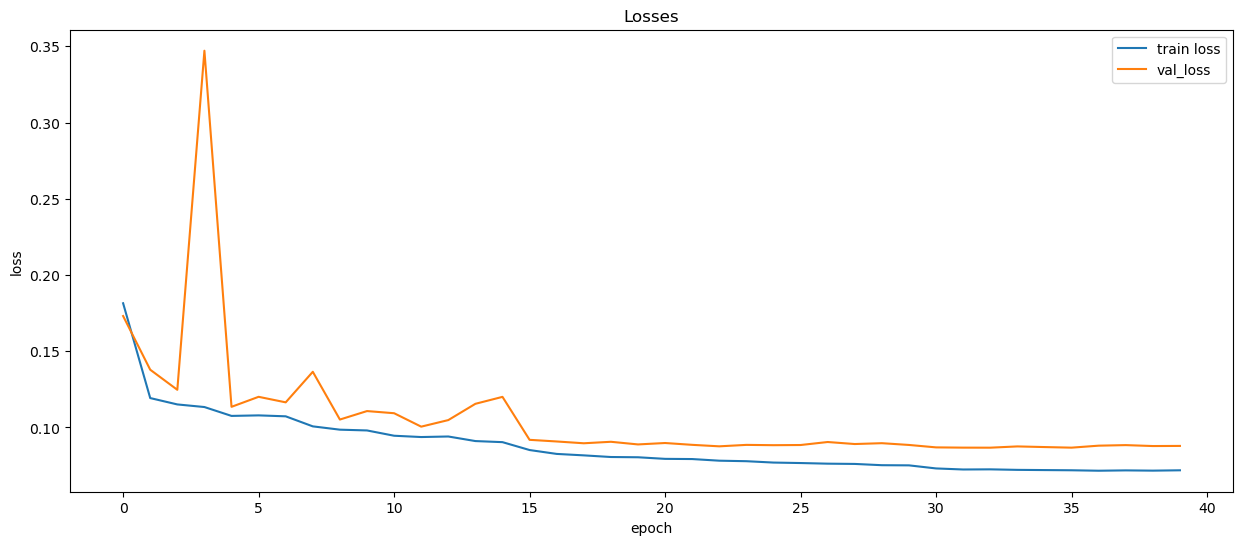

In [8]:
plt.figure(figsize=(15, 6))
plt.plot(df['train_score'])
plt.plot(df['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train loss', 'val_loss'])
plt.title('Losses')

Text(0.5, 1.0, 'Scores')

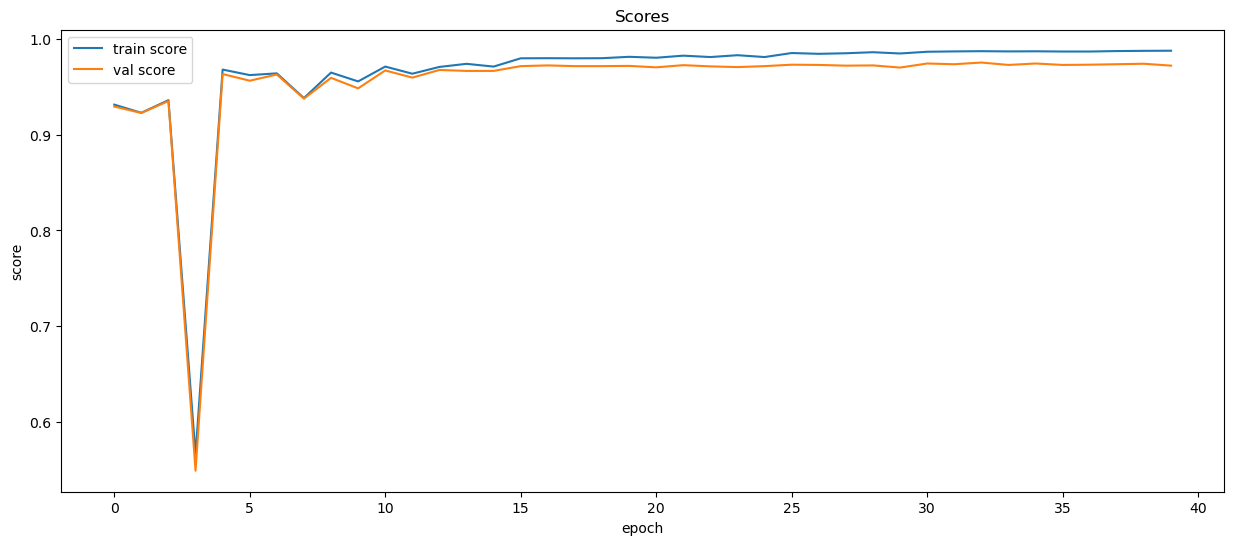

In [11]:
plt.figure(figsize=(15, 6))
plt.plot(df['train_score'])
plt.plot(df['val_score'])
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['train score', 'val score'])
plt.title('Scores')


In [16]:
model.eval()

UNet(
  (stage1): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (stage2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (stage3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3)

Text(0.5, 1.0, 'MASKS')

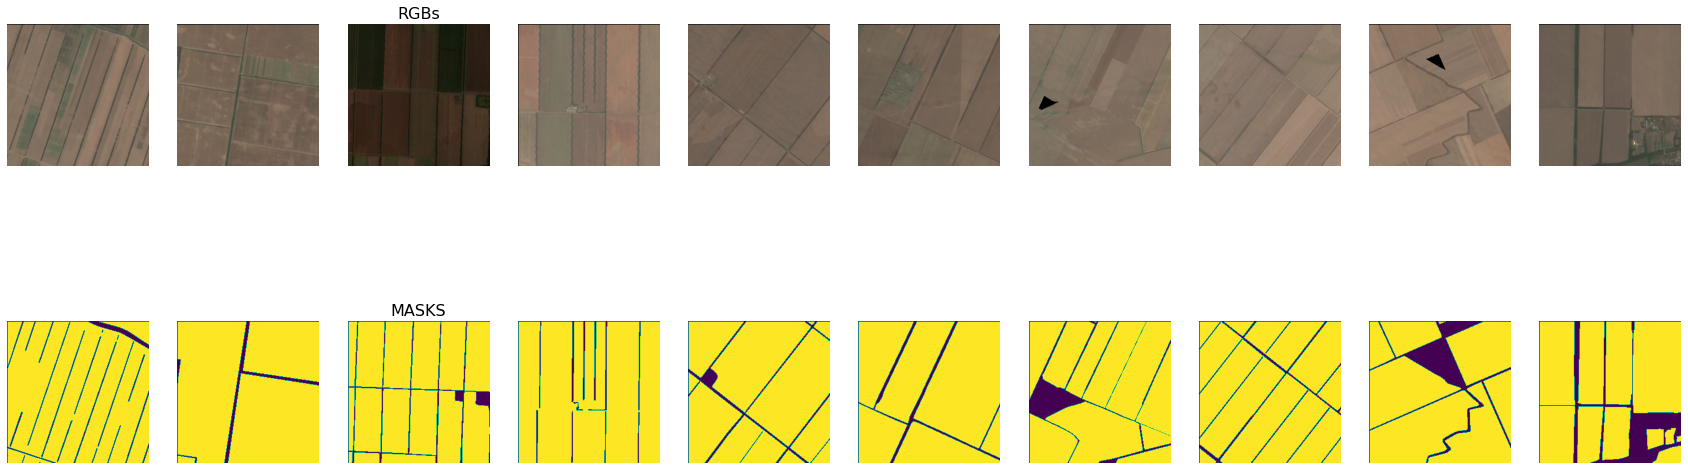

In [23]:
fig, axes = plt.subplots(2,10, figsize=(30,10)) 
for i in range(10):
    dataset = rasterio.plot.reshape_as_raster(images[0:10][i])
    show(dataset[0:3], ax = axes[0,i])
    show(masks[0:10][i], ax = axes[1,i])
    axes[1,i].axis('off')
    axes[0,i].axis('off')
axes[0,2].set_title('RGBs', fontsize = 16)
axes[1,2].set_title('MASKS', fontsize = 16)

In [108]:
images = np.array([], np.float32)
masks = np.array([], np.float32)
for i in tqdm(range(100)):
    image = imread(images_dirs[i])         
    
    image = adjust_band(image) # конвертация в диапозон [0,1]
    image = np.array(image, np.float32)
    images = np.append(images,image )
        
    mask = imread(masks_dirs[i])
    
    mask = np.array(mask, np.float32) 
    masks = np.append(masks,mask )

100%|██████████| 100/100 [00:02<00:00, 36.33it/s]


In [109]:
images = images.reshape(100,256,256,4)
masks = masks.reshape(100,256,256,1)

In [110]:
tensor = torch.tensor(np.rollaxis(images[0:16], 3, 1)).to(device)

In [111]:
result = model(tensor)

In [112]:
res = (result).detach().to('cpu')

In [113]:
res = np.array(res)

In [114]:
masks[0:16].shape

(16, 256, 256, 1)

In [115]:
res = res.reshape(16,256,256)

In [116]:
res = adjust_band(res)

In [117]:
res

array([[[0.30073276, 0.32821393, 0.2954529 , ..., 0.2809745 ,
         0.3190923 , 0.43394688],
        [0.3548834 , 0.6566954 , 0.6976419 , ..., 0.7284191 ,
         0.7193556 , 0.67118126],
        [0.31224483, 0.6758867 , 0.73262435, ..., 0.7783405 ,
         0.74059385, 0.6891178 ],
        ...,
        [0.24711785, 0.7010514 , 0.7470426 , ..., 0.74685997,
         0.7282987 , 0.7136672 ],
        [0.2980956 , 0.6991511 , 0.717715  , ..., 0.7563645 ,
         0.739634  , 0.7139181 ],
        [0.3983605 , 0.6490113 , 0.6721068 , ..., 0.70570004,
         0.7037107 , 0.6690703 ]],

       [[0.3113886 , 0.33646327, 0.30878374, ..., 0.29771778,
         0.34451988, 0.44536695],
        [0.3559382 , 0.62962186, 0.6544453 , ..., 0.71300864,
         0.70944554, 0.66957635],
        [0.32234538, 0.6358222 , 0.6690917 , ..., 0.72711897,
         0.7166557 , 0.6834533 ],
        ...,
        [0.27723217, 0.6907753 , 0.75297874, ..., 0.78225666,
         0.7489156 , 0.7141775 ],
        [0.3

Text(0.5, 1.0, 'result')

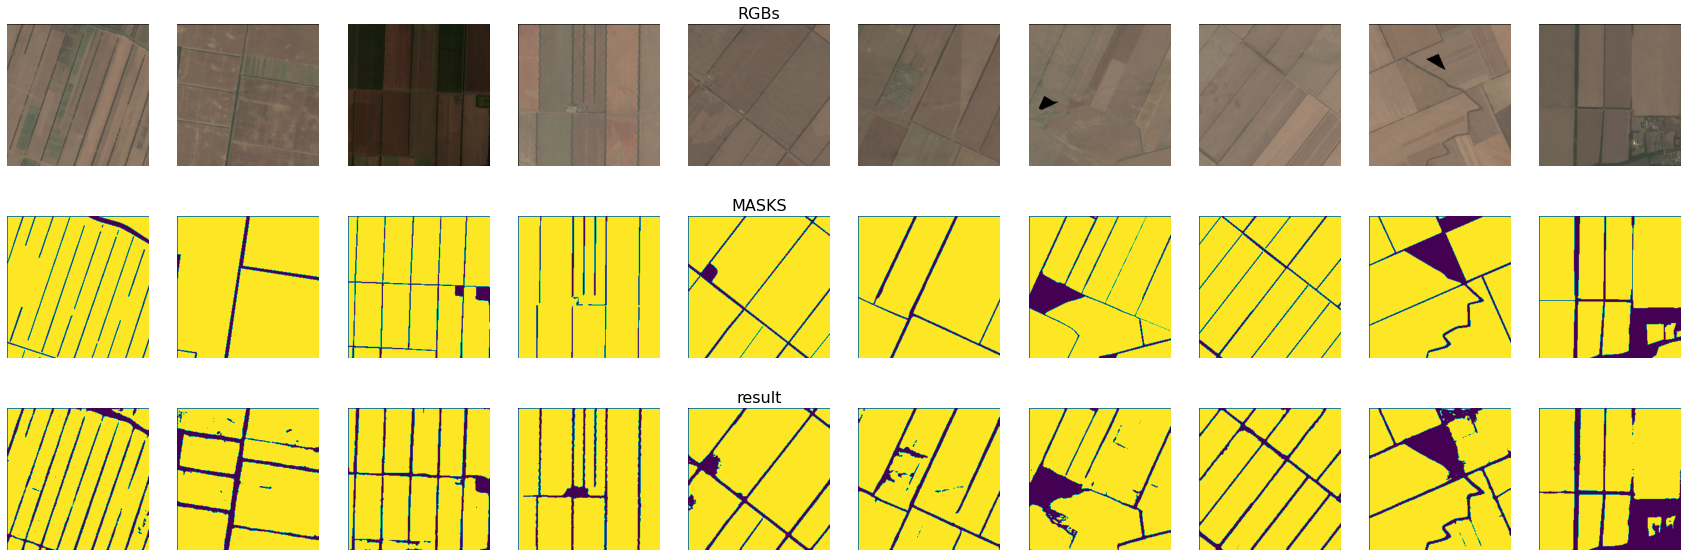

In [118]:
fig, axes = plt.subplots(3,10, figsize=(30,10)) 
for i in range(10):
    dataset = rasterio.plot.reshape_as_raster(images[i])
    show(dataset[0:3], ax = axes[0,i])
    show(res[i]> 0.62, ax = axes[2,i])
    show(masks[i], ax = axes[1,i])
    axes[1,i].axis('off')
    axes[0,i].axis('off')
    axes[2,i].axis('off')

axes[0,4].set_title('RGBs', fontsize = 16)
axes[1,4].set_title('MASKS', fontsize = 16)
axes[2,4].set_title('result', fontsize = 16)